In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tensorflow.keras import regularizers

import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

### Load images

In [2]:
# Lets read the train data and the train labels. 
train_data_directory = 'D:/Brain_Tumor_Data/train'
data_directory = 'D:/Brain_Tumor_Data'
IMAGE_SIZE = 128
NUM_IMAGES = 64
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type="FLAIR", split="test", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

(1, 128, 128, 64)
0.0 1.0 0.06278081447195914 0.00016408131415728857
Dimension of the CT scan is: (128, 128, 64)


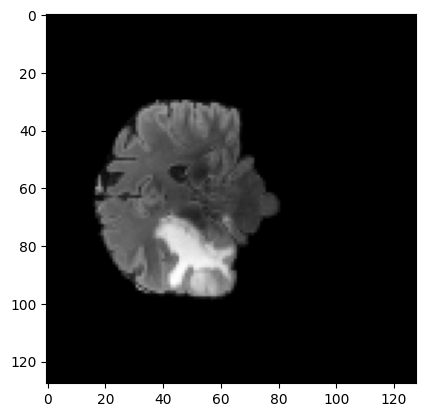

In [3]:
a = load_dicom_images_3d("00001")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

In [4]:
df_train_labels = pd.read_csv('D:/Brain_Tumor_Data/_labels.csv')
df_train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [5]:
train_data_directory = 'D:/Brain_Tumor_Data/train'
print(min(os.listdir(train_data_directory)), max(os.listdir(train_data_directory)))

00000 01010


In [6]:
total_training_scans_F = np.array([load_dicom_images_3d(a, split = 'train') for a in os.listdir(train_data_directory)])
total_training_scans_T1 = np.array([load_dicom_images_3d(a, split = 'train', mri_type="T1w") for a in os.listdir(train_data_directory)])
total_training_scans_T1E = np.array([load_dicom_images_3d(a, split = 'train', mri_type="T1wCE") for a in os.listdir(train_data_directory)])
total_training_scans_T2W = np.array([load_dicom_images_3d(a, split = 'train', mri_type = "T2w") for a in os.listdir(train_data_directory)])

In [7]:
len(total_training_scans_T2W)

585

(585, 1, 128, 128, 64)
585
Dimension of the CT scan is: (1, 128, 128, 64)


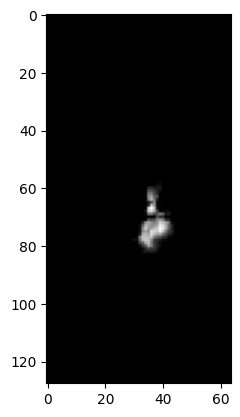

In [8]:
print(total_training_scans_F.shape)
print(len(total_training_scans_F))
image = total_training_scans_F[20]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 25]), cmap="gray")

In [9]:
# Split data
num_train = 374 # 0.64 of 585 samples
num_val = 467 # 0.8 ~~~

x_train_F = np.array([train.T for train in total_training_scans_F[:num_train]])
x_val_F = np.array([train.T for train in total_training_scans_F[num_train:num_val]])
x_test_F = np.array([train.T for train in total_training_scans_F[num_val:]])

x_train_T1 = np.array([train.T for train in total_training_scans_T1[:num_train]])
x_val_T1 = np.array([train.T for train in total_training_scans_T1[num_train:num_val]])
x_test_T1 = np.array([train.T for train in total_training_scans_T1[num_val:]])

x_train_T1E = np.array([train.T for train in total_training_scans_T1E[:num_train]])
x_val_T1E = np.array([train.T for train in total_training_scans_T1E[num_train:num_val]])
x_test_T1E = np.array([train.T for train in total_training_scans_T1E[num_val:]])

x_train_T2W = np.array([train.T for train in total_training_scans_T2W[:num_train]])
x_val_T2W = np.array([train.T for train in total_training_scans_T2W[num_train:num_val]])
x_test_T2W = np.array([train.T for train in total_training_scans_T2W[num_val:]])

In [10]:
print(f"The shape of train: {x_train_T2W.shape}")
print(f"The shape of val: {x_val_T2W.shape}")
print(f"The shape of val: {x_test_T2W.shape}")

The shape of train: (374, 64, 128, 128, 1)
The shape of val: (93, 64, 128, 128, 1)
The shape of val: (118, 64, 128, 128, 1)


In [11]:
total_training_labels = df_train_labels["MGMT_value"].to_list()

In [12]:
total_training_labels = total_training_labels[:585]

In [13]:
len(total_training_labels)

585

In [14]:
y_train = total_training_labels[:num_train]
y_val = total_training_labels[num_train:num_val]
y_test = total_training_labels[num_val:]

### Model

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [16]:
def get_model(drop_out, with_data_aug, width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth,width, height,1))
    if (with_data_aug):
        x = data_augmentation(inputs)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(drop_out, name="Before_Prediction")(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


In [17]:
with tf.device('/device:GPU:0'):
#     auc_list = []
#     auc_with_data_aug = []
#     count = 0
#     for i in np.arange(0, 1, 0.1):
#     for j in np.arange(2):
    # Build model.
    model_F = get_model(drop_out = 0.8, with_data_aug = 0, width=128, height=128, depth=64)
    model_T1 = get_model(drop_out = 0.4, with_data_aug = 0, width=128, height=128, depth=64)
    model_T1E = get_model(drop_out = 0.8, with_data_aug = 0, width=128, height=128, depth=64)
    model_T2W = get_model(drop_out = 0.9, with_data_aug = 0, width=128, height=128, depth=64)
    # Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model_F.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
    )
    model_T1.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
    )
    model_T1E.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
    )
    model_T2W.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
    )

    # Define callbacks.
    checkpoint_F = keras.callbacks.ModelCheckpoint(
       "FLA_MODEL.h5", save_best_only=True
    )
    checkpoint_T1 = keras.callbacks.ModelCheckpoint(
       "T1_MODEL.h5", save_best_only=True
    )
    checkpoint_T1E = keras.callbacks.ModelCheckpoint(
       "T1E_MODEL.h5", save_best_only=True
    )
    checkpoint_T2W = keras.callbacks.ModelCheckpoint(
       "T2W_MODEL.h5", save_best_only=True
    )
    
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)  # TODO

    # Train the model, doing validation at the end of each epoch
    epochs = 10
    history_F = model_F.fit(
        tf.data.Dataset.from_tensor_slices((x_train_F, y_train)).batch(4),
        validation_data=tf.data.Dataset.from_tensor_slices((x_val_F,y_val)).batch(4),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_F, early_stopping_cb],
    )
    history_T1 = model_T1.fit(
        tf.data.Dataset.from_tensor_slices((x_train_T1, y_train)).batch(4),
        validation_data=tf.data.Dataset.from_tensor_slices((x_val_T1,y_val)).batch(4),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_T1, early_stopping_cb],
    )
    history_T1E = model_T1E.fit(
        tf.data.Dataset.from_tensor_slices((x_train_T1E, y_train)).batch(4),
        validation_data=tf.data.Dataset.from_tensor_slices((x_val_T1E,y_val)).batch(4),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_T1E, early_stopping_cb],
    )
    history_T2W = model_T2W.fit(
        tf.data.Dataset.from_tensor_slices((x_train_T2W, y_train)).batch(4),
        validation_data=tf.data.Dataset.from_tensor_slices((x_val_T2W,y_val)).batch(4),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_T2W, early_stopping_cb],
    )
    
#     if (count > 0):
#         if (j):
#             auc_with_data_aug.append(history.history[f'val_auc_{count}'][-1])
#         else:
#             auc_list.append(history.history[f'val_auc_{count}'][-1])
#     else:
#         if (j):
#             auc_with_data_aug.append(history.history['val_auc'][-1])
#         else:
#             auc_list.append(history.history['val_auc'][-1])

#     count += 1



Epoch 1/10
94/94 - 49s - loss: 0.7748 - auc: 0.4926 - acc: 0.4920 - val_loss: 0.7185 - val_auc: 0.4778 - val_acc: 0.3871 - 49s/epoch - 526ms/step
Epoch 2/10
94/94 - 25s - loss: 0.7012 - auc: 0.5712 - acc: 0.5294 - val_loss: 0.8951 - val_auc: 0.4052 - val_acc: 0.3871 - 25s/epoch - 264ms/step
Epoch 3/10
94/94 - 25s - loss: 0.7263 - auc: 0.5555 - acc: 0.5321 - val_loss: 0.8588 - val_auc: 0.4033 - val_acc: 0.3656 - 25s/epoch - 270ms/step
Epoch 4/10
94/94 - 27s - loss: 0.7293 - auc: 0.5422 - acc: 0.5348 - val_loss: 0.8195 - val_auc: 0.4245 - val_acc: 0.3763 - 27s/epoch - 292ms/step
Epoch 5/10
94/94 - 28s - loss: 0.7180 - auc: 0.5720 - acc: 0.5615 - val_loss: 0.7679 - val_auc: 0.4320 - val_acc: 0.4086 - 28s/epoch - 298ms/step
Epoch 6/10
94/94 - 27s - loss: 0.7251 - auc: 0.5463 - acc: 0.5535 - val_loss: 0.6962 - val_auc: 0.4259 - val_acc: 0.5484 - 27s/epoch - 289ms/step
Epoch 7/10
94/94 - 27s - loss: 0.7238 - auc: 0.5623 - acc: 0.5561 - val_loss: 0.7980 - val_auc: 0.4513 - val_acc: 0.4194 - 2

In [18]:
# If have the models in RAM
# If not, then:
#             layer_output_F = keras.load("Fla_model.h5").get_layer("Before_Prediction").output
layer_output_F = model_F.get_layer("Before_Prediction").output
layer_output_T1 = model_T1.get_layer("Before_Prediction").output
layer_output_T1E = model_T1E.get_layer("Before_Prediction").output
layer_output_T2W = model_T2W.get_layer("Before_Prediction").output

feature_extractor_F = keras.Model(
   inputs=model_F.inputs,
   outputs=layer_output_F,
)

feature_extractor_T1 = keras.Model(
   inputs=model_T1.inputs,
   outputs=layer_output_T1,
)

feature_extractor_T1E = keras.Model(
   inputs=model_T1E.inputs,
   outputs=layer_output_T1E,
)

feature_extractor_T2W = keras.Model(
   inputs=model_T2W.inputs,
   outputs=layer_output_T2W,
)

In [19]:
# Practice
a = np.expand_dims(x_train_F[0], axis=0)
a = feature_extractor_F(a)
print(a.shape)
print(x_train_F.shape[0])

(1, 512)
374


In [20]:
# Obtain four features for train
features_F = []
features_T1 = []
features_T1E = []
features_T2W = []
for i in np.arange(0, x_train_F.shape[0], 1):
    features_F.append(feature_extractor_F(np.expand_dims(x_train_F[i], axis=0)))
    features_T1.append(feature_extractor_T1(np.expand_dims(x_train_T1[i], axis=0)))
    features_T1E.append(feature_extractor_T1E(np.expand_dims(x_train_T1E[i], axis=0)))
    features_T2W.append(feature_extractor_T2W(np.expand_dims(x_train_T2W[i], axis=0)))

In [21]:
print(np.array(features_F).shape)

(374, 1, 512)


In [22]:
# Obtain four features for validation
features_F_val = []
features_T1_val = []
features_T1E_val = []
features_T2W_val = []

for i in np.arange(0, x_val_F.shape[0], 1):
    features_F_val.append(feature_extractor_F(np.expand_dims(x_val_F[i], axis=0)))
    features_T1_val.append(feature_extractor_T1(np.expand_dims(x_val_T1[i], axis=0)))
    features_T1E_val.append(feature_extractor_T1E(np.expand_dims(x_val_T1E[i], axis=0)))
    features_T2W_val.append(feature_extractor_T2W(np.expand_dims(x_val_T2W[i], axis=0)))

In [23]:
# Obtain four features for test (development set)
features_F_dev = []
features_T1_dev = []
features_T1E_dev = []
features_T2W_dev = []

for i in np.arange(0, x_test_F.shape[0], 1):
    features_F_dev.append(feature_extractor_F(np.expand_dims(x_test_F[i], axis=0)))
    features_T1_dev.append(feature_extractor_T1(np.expand_dims(x_test_T1[i], axis=0)))
    features_T1E_dev.append(feature_extractor_T1E(np.expand_dims(x_test_T1E[i], axis=0)))
    features_T2W_dev.append(feature_extractor_T2W(np.expand_dims(x_test_T2W[i], axis=0)))

In [24]:
print(np.array(features_F_val).shape)

(93, 1, 512)


In [25]:
print(np.array(features_F_dev).shape)

(118, 1, 512)


In [26]:
# Change data type and shape (Combining)
features_F = np.array(features_F)
features_T1 = np.array(features_T1)
features_T1E = np.array(features_T1E)
features_T2W = np.array(features_T2W)

features_F_val = np.array(features_F_val)
features_T1_val = np.array(features_T1_val)
features_T1E_val = np.array(features_T1E_val)
features_T2W_val = np.array(features_T2W_val)

features_F_dev = np.array(features_F_dev)
features_T1_dev = np.array(features_T1_dev)
features_T1E_dev = np.array(features_T1E_dev)
features_T2W_dev = np.array(features_T2W_dev)


data_train = np.append(features_F, features_T1, axis=2)
data_train = np.append(data_train, features_T1E, axis=2)
data_train = np.append(data_train, features_T2W, axis=2)

data_val = np.append(features_F_val, features_T1_val, axis=2)
data_val = np.append(data_val, features_T1E_val, axis=2)
data_val = np.append(data_val, features_T2W_val, axis=2)

data_dev = np.append(features_F_dev, features_T1_dev, axis=2)
data_dev = np.append(data_dev, features_T1E_dev, axis=2)
data_dev = np.append(data_dev, features_T2W_dev, axis=2)

In [27]:
print(data_dev.shape)

(118, 1, 2048)


In [28]:
def get_big_model(l2_value, dropout_value):
    inputs = keras.Input(shape=(1, 2048))
    features = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_value))(inputs) 
    features = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_value))(features)  
    features = layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_value))(features)  
    
    # L2 = 0.04 gives auc of 0.607 (epoch 2)

    features = layers.Dropout(dropout_value)(features) # loop                                        

    output_lay = layers.Dense(units=1, activation="sigmoid")(features)
    model = keras.Model(inputs, outputs=output_lay)
    return model

In [35]:
# Check data shape and fit the need for the model
print(f"train data shape: {data_train.shape}")
print(f"val data shape: {data_val.shape}")

y_train_np = np.expand_dims(y_train, axis=1)
y_val_np = np.expand_dims(y_val, axis=1)

print(f"train label shape: {y_train_np.shape}")
print(f"val label shape: {y_val_np.shape}")

# Compile the model
L2_interested = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 
                 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3]

Dropout_interested = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i = 26

# L2_interested = [0.06]

for l2_value in L2_interested:
    for dropout_value in Dropout_interested:
        print(l2_value, dropout_value)
        model = get_big_model(l2_value, dropout_value)
        model.compile(loss="binary_crossentropy", 
                      optimizer="rmsprop",
                      metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')])

        checkpoint_cb = keras.callbacks.ModelCheckpoint(
                       "BIG_MODEL2.h5", save_best_only=True
                    )
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor=f"val_auc_{i}", patience=5)  # decrease patience from 15 to 5

#       early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

        history = model.fit(
                        tf.data.Dataset.from_tensor_slices((data_train, y_train_np)).batch(2),  # decrease batch from 4 to 2
                        validation_data=tf.data.Dataset.from_tensor_slices((data_val, y_val_np)).batch(2),
                        epochs=10,
                        shuffle=True,
                        verbose=2,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                    )
        i += 1

train data shape: (374, 1, 2048)
val data shape: (93, 1, 2048)
train label shape: (374, 1)
val label shape: (93, 1)
0 0
Epoch 1/10
187/187 - 2s - loss: 0.7130 - auc_26: 0.5169 - acc: 0.5241 - val_loss: 0.6672 - val_auc_26: 0.5280 - val_acc: 0.6022 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.6991 - auc_26: 0.5523 - acc: 0.5374 - val_loss: 0.6717 - val_auc_26: 0.5119 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6813 - auc_26: 0.6021 - acc: 0.5722 - val_loss: 0.7127 - val_auc_26: 0.4627 - val_acc: 0.6022 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6768 - auc_26: 0.6288 - acc: 0.5802 - val_loss: 0.7330 - val_auc_26: 0.4011 - val_acc: 0.6022 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6643 - auc_26: 0.6521 - acc: 0.5989 - val_loss: 0.7711 - val_auc_26: 0.3811 - val_acc: 0.6129 - 1s/epoch - 5ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6564 - auc_26: 0.6628 - acc: 0.6390 - val_loss: 0.7869 - val_auc_26: 0.3726 - val_acc: 0.6129 -

Epoch 8/10
187/187 - 1s - loss: 0.6335 - auc_31: 0.7047 - acc: 0.6364 - val_loss: 0.7300 - val_auc_31: 0.3962 - val_acc: 0.5699 - 1s/epoch - 6ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6432 - auc_31: 0.6955 - acc: 0.6471 - val_loss: 0.7334 - val_auc_31: 0.4133 - val_acc: 0.5699 - 1s/epoch - 6ms/step
Epoch 10/10
187/187 - 1s - loss: 0.6297 - auc_31: 0.7410 - acc: 0.6765 - val_loss: 0.8825 - val_auc_31: 0.3991 - val_acc: 0.5269 - 1s/epoch - 6ms/step
0 0.6
Epoch 1/10
187/187 - 2s - loss: 0.7517 - auc_32: 0.5112 - acc: 0.5000 - val_loss: 0.6772 - val_auc_32: 0.4476 - val_acc: 0.6129 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7100 - auc_32: 0.5608 - acc: 0.5588 - val_loss: 0.6824 - val_auc_32: 0.4605 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6997 - auc_32: 0.5639 - acc: 0.5695 - val_loss: 0.6744 - val_auc_32: 0.4664 - val_acc: 0.6237 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7051 - auc_32: 0.5770 - acc: 0.5561 - val_loss: 0.6780 - v

Epoch 7/10
187/187 - 1s - loss: 0.6402 - auc_37: 0.7143 - acc: 0.6631 - val_loss: 0.7939 - val_auc_37: 0.3989 - val_acc: 0.5269 - 1s/epoch - 6ms/step
Epoch 8/10
187/187 - 1s - loss: 0.6208 - auc_37: 0.7374 - acc: 0.7005 - val_loss: 0.8288 - val_auc_37: 0.3967 - val_acc: 0.5161 - 1s/epoch - 6ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6027 - auc_37: 0.7612 - acc: 0.7193 - val_loss: 0.8568 - val_auc_37: 0.4133 - val_acc: 0.5269 - 1s/epoch - 6ms/step
0.001 0.2
Epoch 1/10
187/187 - 3s - loss: 0.8168 - auc_38: 0.5104 - acc: 0.5053 - val_loss: 0.7181 - val_auc_38: 0.4654 - val_acc: 0.6022 - 3s/epoch - 13ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7411 - auc_38: 0.5273 - acc: 0.5294 - val_loss: 0.7030 - val_auc_38: 0.3989 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6979 - auc_38: 0.5977 - acc: 0.5642 - val_loss: 0.6864 - val_auc_38: 0.4345 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6915 - auc_38: 0.6211 - acc: 0.6123 - val_loss: 0.7086 

187/187 - 1s - loss: 0.6938 - auc_43: 0.5369 - acc: 0.5241 - val_loss: 0.6891 - val_auc_43: 0.5341 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6965 - auc_43: 0.5576 - acc: 0.4866 - val_loss: 0.6949 - val_auc_43: 0.5173 - val_acc: 0.6022 - 1s/epoch - 7ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6966 - auc_43: 0.5002 - acc: 0.4973 - val_loss: 0.6950 - val_auc_43: 0.4800 - val_acc: 0.5269 - 1s/epoch - 7ms/step
Epoch 8/10
187/187 - 1s - loss: 0.6915 - auc_43: 0.5367 - acc: 0.5401 - val_loss: 0.6875 - val_auc_43: 0.5275 - val_acc: 0.6237 - 1s/epoch - 7ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6952 - auc_43: 0.5037 - acc: 0.5134 - val_loss: 0.6920 - val_auc_43: 0.5158 - val_acc: 0.6022 - 1s/epoch - 7ms/step
0.001 0.8
Epoch 1/10
187/187 - 2s - loss: 0.8514 - auc_44: 0.4713 - acc: 0.5027 - val_loss: 0.7478 - val_auc_44: 0.4630 - val_acc: 0.3763 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7299 - auc_44: 0.4638 - acc: 0.4519 - val_loss: 0.7041 - val_auc_4

Epoch 5/10
187/187 - 1s - loss: 0.6941 - auc_49: 0.5964 - acc: 0.5642 - val_loss: 0.6873 - val_auc_49: 0.3655 - val_acc: 0.6022 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6863 - auc_49: 0.6072 - acc: 0.5936 - val_loss: 0.6844 - val_auc_49: 0.3745 - val_acc: 0.6022 - 1s/epoch - 6ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6760 - auc_49: 0.6442 - acc: 0.6150 - val_loss: 0.6961 - val_auc_49: 0.3499 - val_acc: 0.6022 - 1s/epoch - 7ms/step
Epoch 8/10
187/187 - 1s - loss: 0.6702 - auc_49: 0.6542 - acc: 0.6310 - val_loss: 0.6980 - val_auc_49: 0.3962 - val_acc: 0.5806 - 1s/epoch - 6ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6565 - auc_49: 0.6794 - acc: 0.6551 - val_loss: 0.7283 - val_auc_49: 0.3748 - val_acc: 0.5699 - 1s/epoch - 6ms/step
Epoch 10/10
187/187 - 1s - loss: 0.6439 - auc_49: 0.7033 - acc: 0.6497 - val_loss: 0.7281 - val_auc_49: 0.3762 - val_acc: 0.5914 - 1s/epoch - 6ms/step
0.002 0.4
Epoch 1/10
187/187 - 2s - loss: 0.8588 - auc_50: 0.5356 - acc: 0.5321 - val_loss: 0.7302 

Epoch 8/10
187/187 - 1s - loss: 0.6957 - auc_55: 0.4491 - acc: 0.4893 - val_loss: 0.6927 - val_auc_55: 0.4898 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6935 - auc_55: 0.4817 - acc: 0.4973 - val_loss: 0.6921 - val_auc_55: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.003 0
Epoch 1/10
187/187 - 2s - loss: 0.8998 - auc_56: 0.5233 - acc: 0.5374 - val_loss: 0.7409 - val_auc_56: 0.4686 - val_acc: 0.6129 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7428 - auc_56: 0.5528 - acc: 0.5535 - val_loss: 0.6996 - val_auc_56: 0.4890 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7112 - auc_56: 0.5867 - acc: 0.5749 - val_loss: 0.6902 - val_auc_56: 0.4191 - val_acc: 0.6344 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6974 - auc_56: 0.6063 - acc: 0.5829 - val_loss: 0.6937 - val_auc_56: 0.4150 - val_acc: 0.6344 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6827 - auc_56: 0.6407 - acc: 0.6310 - val_loss: 0.7130 - 

Epoch 6/10
187/187 - 1s - loss: 0.6972 - auc_61: 0.5267 - acc: 0.5455 - val_loss: 0.6828 - val_auc_61: 0.4917 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6949 - auc_61: 0.5612 - acc: 0.5374 - val_loss: 0.6805 - val_auc_61: 0.5551 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.003 0.6
Epoch 1/10
187/187 - 2s - loss: 0.9255 - auc_62: 0.5176 - acc: 0.5027 - val_loss: 0.7473 - val_auc_62: 0.5634 - val_acc: 0.6452 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7565 - auc_62: 0.5253 - acc: 0.5374 - val_loss: 0.7248 - val_auc_62: 0.4505 - val_acc: 0.3978 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7222 - auc_62: 0.5168 - acc: 0.5214 - val_loss: 0.7016 - val_auc_62: 0.4267 - val_acc: 0.6022 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6989 - auc_62: 0.5979 - acc: 0.6123 - val_loss: 0.6852 - val_auc_62: 0.5653 - val_acc: 0.6129 - 988ms/epoch - 5ms/step
Epoch 5/10
187/187 - 1s - loss: 0.7020 - auc_62: 0.5231 - acc: 0.5107 - val_loss: 0.68

187/187 - 2s - loss: 0.9933 - auc_68: 0.5227 - acc: 0.5267 - val_loss: 0.7776 - val_auc_68: 0.5134 - val_acc: 0.6129 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7652 - auc_68: 0.5684 - acc: 0.5561 - val_loss: 0.7075 - val_auc_68: 0.5122 - val_acc: 0.6237 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7166 - auc_68: 0.5875 - acc: 0.5695 - val_loss: 0.6911 - val_auc_68: 0.5409 - val_acc: 0.6022 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7000 - auc_68: 0.5755 - acc: 0.5481 - val_loss: 0.6761 - val_auc_68: 0.5763 - val_acc: 0.6129 - 999ms/epoch - 5ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6954 - auc_68: 0.5866 - acc: 0.5882 - val_loss: 0.6812 - val_auc_68: 0.5127 - val_acc: 0.6237 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6888 - auc_68: 0.6053 - acc: 0.6043 - val_loss: 0.6813 - val_auc_68: 0.5024 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6954 - auc_68: 0.5874 - acc: 0.5936 - val_loss: 0.6810 - val_auc_68: 0.47

Epoch 3/10
187/187 - 1s - loss: 0.7386 - auc_74: 0.5749 - acc: 0.5508 - val_loss: 0.6975 - val_auc_74: 0.5426 - val_acc: 0.6022 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7210 - auc_74: 0.5207 - acc: 0.5160 - val_loss: 0.7032 - val_auc_74: 0.4912 - val_acc: 0.5914 - 845ms/epoch - 5ms/step
Epoch 5/10
187/187 - 1s - loss: 0.7031 - auc_74: 0.5422 - acc: 0.5241 - val_loss: 0.6906 - val_auc_74: 0.5422 - val_acc: 0.6237 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.7024 - auc_74: 0.5078 - acc: 0.5321 - val_loss: 0.6937 - val_auc_74: 0.3942 - val_acc: 0.6022 - 1s/epoch - 6ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6991 - auc_74: 0.4955 - acc: 0.4947 - val_loss: 0.6893 - val_auc_74: 0.4803 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 8/10
187/187 - 1s - loss: 0.6964 - auc_74: 0.5322 - acc: 0.5374 - val_loss: 0.6898 - val_auc_74: 0.5161 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6949 - auc_74: 0.4851 - acc: 0.5241 - val_loss: 0.6890 - val_au

Epoch 2/10
187/187 - 1s - loss: 0.7989 - auc_81: 0.5175 - acc: 0.5053 - val_loss: 0.7119 - val_auc_81: 0.5200 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7407 - auc_81: 0.5425 - acc: 0.5348 - val_loss: 0.7056 - val_auc_81: 0.4708 - val_acc: 0.6237 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7245 - auc_81: 0.5239 - acc: 0.5134 - val_loss: 0.6999 - val_auc_81: 0.5514 - val_acc: 0.5914 - 1s/epoch - 7ms/step
Epoch 5/10
187/187 - 1s - loss: 0.7152 - auc_81: 0.5199 - acc: 0.5481 - val_loss: 0.6996 - val_auc_81: 0.4637 - val_acc: 0.6237 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.7044 - auc_81: 0.5781 - acc: 0.5695 - val_loss: 0.6905 - val_auc_81: 0.5602 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.005 0.6
Epoch 1/10
187/187 - 2s - loss: 1.0654 - auc_82: 0.5404 - acc: 0.5481 - val_loss: 0.7880 - val_auc_82: 0.5234 - val_acc: 0.6129 - 2s/epoch - 13ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7815 - auc_82: 0.5219 - acc: 0.5321 - val_loss: 0.7220 

Epoch 9/10
187/187 - 1s - loss: 0.6935 - auc_87: 0.4925 - acc: 0.4973 - val_loss: 0.6922 - val_auc_87: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.006 0.2
Epoch 1/10
187/187 - 2s - loss: 1.0610 - auc_88: 0.5478 - acc: 0.5187 - val_loss: 0.8052 - val_auc_88: 0.4581 - val_acc: 0.6344 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7808 - auc_88: 0.5632 - acc: 0.5374 - val_loss: 0.7296 - val_auc_88: 0.5112 - val_acc: 0.5806 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7162 - auc_88: 0.5497 - acc: 0.5401 - val_loss: 0.6940 - val_auc_88: 0.5241 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7000 - auc_88: 0.5587 - acc: 0.5561 - val_loss: 0.6901 - val_auc_88: 0.4613 - val_acc: 0.6237 - 959ms/epoch - 5ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6976 - auc_88: 0.5752 - acc: 0.5668 - val_loss: 0.6905 - val_auc_88: 0.4198 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6953 - auc_88: 0.5828 - acc: 0.5722 - val_loss: 0.68

Epoch 4/10
187/187 - 1s - loss: 0.7049 - auc_94: 0.5098 - acc: 0.4652 - val_loss: 0.6814 - val_auc_94: 0.5709 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.7023 - auc_94: 0.5034 - acc: 0.4893 - val_loss: 0.6831 - val_auc_94: 0.5502 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.7026 - auc_94: 0.5334 - acc: 0.4947 - val_loss: 0.6881 - val_auc_94: 0.5524 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6964 - auc_94: 0.4913 - acc: 0.4920 - val_loss: 0.6934 - val_auc_94: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 8/10
187/187 - 1s - loss: 0.6935 - auc_94: 0.4704 - acc: 0.5027 - val_loss: 0.6930 - val_auc_94: 0.5000 - val_acc: 0.6129 - 914ms/epoch - 5ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6935 - auc_94: 0.4885 - acc: 0.4920 - val_loss: 0.6928 - val_auc_94: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 10/10
187/187 - 1s - loss: 0.6935 - auc_94: 0.4936 - acc: 0.4706 - val_loss: 0.6927 - val_a

Epoch 3/10
187/187 - 1s - loss: 0.7550 - auc_101: 0.5170 - acc: 0.5134 - val_loss: 0.7073 - val_auc_101: 0.5227 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7168 - auc_101: 0.5149 - acc: 0.4840 - val_loss: 0.7052 - val_auc_101: 0.5073 - val_acc: 0.4516 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.7005 - auc_101: 0.4708 - acc: 0.4947 - val_loss: 0.6956 - val_auc_101: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6938 - auc_101: 0.4921 - acc: 0.4920 - val_loss: 0.6942 - val_auc_101: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
0.007 0.6
Epoch 1/10
187/187 - 2s - loss: 1.0977 - auc_102: 0.4864 - acc: 0.4920 - val_loss: 0.8109 - val_auc_102: 0.5556 - val_acc: 0.5699 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7576 - auc_102: 0.5020 - acc: 0.5000 - val_loss: 0.7013 - val_auc_102: 0.5928 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7085 - auc_102: 0.5334 - acc: 0.5615 - val_

0.008 0.3
Epoch 1/10
187/187 - 2s - loss: 1.1745 - auc_109: 0.5517 - acc: 0.5588 - val_loss: 0.8391 - val_auc_109: 0.5317 - val_acc: 0.6129 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7912 - auc_109: 0.5142 - acc: 0.5053 - val_loss: 0.7257 - val_auc_109: 0.6104 - val_acc: 0.6022 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7183 - auc_109: 0.5535 - acc: 0.5294 - val_loss: 0.6966 - val_auc_109: 0.4661 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7037 - auc_109: 0.5712 - acc: 0.5508 - val_loss: 0.6866 - val_auc_109: 0.5219 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6996 - auc_109: 0.5182 - acc: 0.4920 - val_loss: 0.6863 - val_auc_109: 0.5821 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6956 - auc_109: 0.5106 - acc: 0.5214 - val_loss: 0.6885 - val_auc_109: 0.5329 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6955 - auc_109: 0.4900 - acc: 0.4840 - val_

Epoch 8/10
187/187 - 1s - loss: 0.6939 - auc_116: 0.5028 - acc: 0.4947 - val_loss: 0.6942 - val_auc_116: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6938 - auc_116: 0.4755 - acc: 0.4786 - val_loss: 0.6929 - val_auc_116: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 10/10
187/187 - 1s - loss: 0.6937 - auc_116: 0.4598 - acc: 0.4706 - val_loss: 0.6924 - val_auc_116: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.009 0.1
Epoch 1/10
187/187 - 2s - loss: 1.1813 - auc_117: 0.5280 - acc: 0.5267 - val_loss: 0.8253 - val_auc_117: 0.5095 - val_acc: 0.6237 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7652 - auc_117: 0.5312 - acc: 0.5428 - val_loss: 0.7079 - val_auc_117: 0.5439 - val_acc: 0.6237 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7066 - auc_117: 0.5351 - acc: 0.5455 - val_loss: 0.6933 - val_auc_117: 0.5997 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6977 - auc_117: 0.5367 - acc: 0.5668 - val

Epoch 3/10
187/187 - 1s - loss: 0.7077 - auc_124: 0.5098 - acc: 0.4973 - val_loss: 0.6950 - val_auc_124: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6940 - auc_124: 0.4794 - acc: 0.4947 - val_loss: 0.6933 - val_auc_124: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6937 - auc_124: 0.4750 - acc: 0.4973 - val_loss: 0.6929 - val_auc_124: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6934 - auc_124: 0.5145 - acc: 0.5160 - val_loss: 0.6927 - val_auc_124: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
0.009 0.9
Epoch 1/10
187/187 - 2s - loss: 1.2678 - auc_125: 0.5420 - acc: 0.5187 - val_loss: 0.8554 - val_auc_125: 0.5378 - val_acc: 0.5699 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7987 - auc_125: 0.4901 - acc: 0.4973 - val_loss: 0.7433 - val_auc_125: 0.4186 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7193 - auc_125: 0.4637 - acc: 0.4572 - val_

Epoch 7/10
187/187 - 1s - loss: 0.6938 - auc_131: 0.4871 - acc: 0.4866 - val_loss: 0.6938 - val_auc_131: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 8/10
187/187 - 1s - loss: 0.6942 - auc_131: 0.4622 - acc: 0.4920 - val_loss: 0.6935 - val_auc_131: 0.5000 - val_acc: 0.6129 - 1s/epoch - 5ms/step
Epoch 9/10
187/187 - 1s - loss: 0.6941 - auc_131: 0.4592 - acc: 0.4706 - val_loss: 0.6942 - val_auc_131: 0.5000 - val_acc: 0.6129 - 759ms/epoch - 4ms/step
0.01 0.6
Epoch 1/10
187/187 - 2s - loss: 1.2784 - auc_132: 0.4777 - acc: 0.4813 - val_loss: 0.8370 - val_auc_132: 0.5772 - val_acc: 0.6129 - 2s/epoch - 13ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7954 - auc_132: 0.5135 - acc: 0.5241 - val_loss: 0.7127 - val_auc_132: 0.5122 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7276 - auc_132: 0.5214 - acc: 0.4973 - val_loss: 0.7028 - val_auc_132: 0.5029 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7062 - auc_132: 0.5327 - acc: 0.5187 - va

Epoch 2/10
187/187 - 1s - loss: 0.7773 - auc_139: 0.4604 - acc: 0.4840 - val_loss: 0.7036 - val_auc_139: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6957 - auc_139: 0.4975 - acc: 0.4920 - val_loss: 0.6946 - val_auc_139: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6940 - auc_139: 0.4696 - acc: 0.4866 - val_loss: 0.6943 - val_auc_139: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6940 - auc_139: 0.4851 - acc: 0.4759 - val_loss: 0.6940 - val_auc_139: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6940 - auc_139: 0.4963 - acc: 0.4813 - val_loss: 0.6938 - val_auc_139: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6940 - auc_139: 0.4854 - acc: 0.4973 - val_loss: 0.6936 - val_auc_139: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.02 0.4
Epoch 1/10
187/187 - 2s - loss: 1.6970 - auc_140: 0.5149 - acc: 0.5027 - val_lo

Epoch 6/10
187/187 - 1s - loss: 0.6943 - auc_146: 0.4835 - acc: 0.4920 - val_loss: 0.6923 - val_auc_146: 0.5000 - val_acc: 0.6129 - 910ms/epoch - 5ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6943 - auc_146: 0.4837 - acc: 0.5027 - val_loss: 0.6924 - val_auc_146: 0.5000 - val_acc: 0.6129 - 787ms/epoch - 4ms/step
Epoch 8/10
187/187 - 1s - loss: 0.6944 - auc_146: 0.4613 - acc: 0.4920 - val_loss: 0.6922 - val_auc_146: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.03 0.1
Epoch 1/10
187/187 - 3s - loss: 1.9101 - auc_147: 0.5414 - acc: 0.5455 - val_loss: 0.9110 - val_auc_147: 0.5078 - val_acc: 0.6129 - 3s/epoch - 14ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7739 - auc_147: 0.5000 - acc: 0.5080 - val_loss: 0.7045 - val_auc_147: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6962 - auc_147: 0.5002 - acc: 0.4947 - val_loss: 0.6947 - val_auc_147: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6943 - auc_147: 0.4912 - acc: 0.4840 -

Epoch 3/10
187/187 - 1s - loss: 0.7101 - auc_154: 0.4627 - acc: 0.4893 - val_loss: 0.6947 - val_auc_154: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6951 - auc_154: 0.4713 - acc: 0.4866 - val_loss: 0.6930 - val_auc_154: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6943 - auc_154: 0.4870 - acc: 0.4973 - val_loss: 0.6929 - val_auc_154: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6943 - auc_154: 0.4870 - acc: 0.4920 - val_loss: 0.6929 - val_auc_154: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6943 - auc_154: 0.4975 - acc: 0.4920 - val_loss: 0.6928 - val_auc_154: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
0.03 0.9
Epoch 1/10
187/187 - 2s - loss: 2.2908 - auc_155: 0.4455 - acc: 0.4545 - val_loss: 1.0904 - val_auc_155: 0.5037 - val_acc: 0.6129 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.9008 - auc_155: 0.4939 - acc: 0.5000 - val_l

0.04 0.6
Epoch 1/10
187/187 - 2s - loss: 2.3902 - auc_162: 0.5306 - acc: 0.5428 - val_loss: 1.0437 - val_auc_162: 0.5163 - val_acc: 0.6129 - 2s/epoch - 13ms/step
Epoch 2/10
187/187 - 1s - loss: 0.8239 - auc_162: 0.5151 - acc: 0.5160 - val_loss: 0.7095 - val_auc_162: 0.5390 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7022 - auc_162: 0.5386 - acc: 0.4920 - val_loss: 0.6924 - val_auc_162: 0.5322 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6948 - auc_162: 0.4829 - acc: 0.5080 - val_loss: 0.6915 - val_auc_162: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6957 - auc_162: 0.4376 - acc: 0.4840 - val_loss: 0.6931 - val_auc_162: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6948 - auc_162: 0.4669 - acc: 0.4786 - val_loss: 0.6932 - val_auc_162: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6946 - auc_162: 0.4753 - acc: 0.4947 - val_l

Epoch 4/10
187/187 - 1s - loss: 0.6951 - auc_169: 0.5052 - acc: 0.4866 - val_loss: 0.6937 - val_auc_169: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6948 - auc_169: 0.5174 - acc: 0.5080 - val_loss: 0.6933 - val_auc_169: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6949 - auc_169: 0.4963 - acc: 0.4893 - val_loss: 0.6932 - val_auc_169: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6950 - auc_169: 0.4964 - acc: 0.5321 - val_loss: 0.6936 - val_auc_169: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.05 0.4
Epoch 1/10
187/187 - 3s - loss: 2.8669 - auc_170: 0.5504 - acc: 0.5428 - val_loss: 1.1125 - val_auc_170: 0.4866 - val_acc: 0.6129 - 3s/epoch - 14ms/step
Epoch 2/10
187/187 - 1s - loss: 0.8620 - auc_170: 0.5512 - acc: 0.5481 - val_loss: 0.7170 - val_auc_170: 0.5373 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7016 - auc_170: 0.5007 - acc: 0.4973 - val_l

Epoch 4/10
187/187 - 1s - loss: 0.6953 - auc_177: 0.4874 - acc: 0.4920 - val_loss: 0.6941 - val_auc_177: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6953 - auc_177: 0.4979 - acc: 0.5027 - val_loss: 0.6940 - val_auc_177: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6953 - auc_177: 0.4817 - acc: 0.4973 - val_loss: 0.6940 - val_auc_177: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
0.06 0.2
Epoch 1/10
187/187 - 2s - loss: 2.9303 - auc_178: 0.5033 - acc: 0.4973 - val_loss: 1.0389 - val_auc_178: 0.5599 - val_acc: 0.6129 - 2s/epoch - 13ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7996 - auc_178: 0.5160 - acc: 0.5160 - val_loss: 0.7028 - val_auc_178: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6959 - auc_178: 0.4871 - acc: 0.4973 - val_loss: 0.6982 - val_auc_178: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6954 - auc_178: 0.5114 - acc: 0.4973 - val_l

0.07 0
Epoch 1/10
187/187 - 2s - loss: 3.2277 - auc_186: 0.5348 - acc: 0.5615 - val_loss: 1.0498 - val_auc_186: 0.5034 - val_acc: 0.6129 - 2s/epoch - 11ms/step
Epoch 2/10
187/187 - 1s - loss: 0.7898 - auc_186: 0.4991 - acc: 0.5187 - val_loss: 0.6981 - val_auc_186: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6958 - auc_186: 0.4963 - acc: 0.4759 - val_loss: 0.6955 - val_auc_186: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6956 - auc_186: 0.4854 - acc: 0.4973 - val_loss: 0.6953 - val_auc_186: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6956 - auc_186: 0.4704 - acc: 0.4973 - val_loss: 0.6951 - val_auc_186: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6956 - auc_186: 0.4885 - acc: 0.4920 - val_loss: 0.6949 - val_auc_186: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6956 - auc_186: 0.4936 - acc: 0.4706 - val_los

Epoch 3/10
187/187 - 1s - loss: 0.6968 - auc_194: 0.4865 - acc: 0.5027 - val_loss: 0.6964 - val_auc_194: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6961 - auc_194: 0.4823 - acc: 0.4679 - val_loss: 0.6962 - val_auc_194: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6958 - auc_194: 0.5065 - acc: 0.5107 - val_loss: 0.6966 - val_auc_194: 0.5000 - val_acc: 0.3871 - 1s/epoch - 5ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6956 - auc_194: 0.5161 - acc: 0.5187 - val_loss: 0.6961 - val_auc_194: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6959 - auc_194: 0.4914 - acc: 0.5080 - val_loss: 0.6954 - val_auc_194: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.07 0.9
Epoch 1/10
187/187 - 2s - loss: 3.5187 - auc_195: 0.5128 - acc: 0.4893 - val_loss: 1.2354 - val_auc_195: 0.4810 - val_acc: 0.5806 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.9076 - auc_195: 0.4833 - acc: 0.5053 - val_l

Epoch 2/10
187/187 - 1s - loss: 0.8308 - auc_202: 0.5304 - acc: 0.5294 - val_loss: 0.7045 - val_auc_202: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6991 - auc_202: 0.4996 - acc: 0.5080 - val_loss: 0.6911 - val_auc_202: 0.5000 - val_acc: 0.6129 - 975ms/epoch - 5ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6967 - auc_202: 0.4756 - acc: 0.4973 - val_loss: 0.6919 - val_auc_202: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6963 - auc_202: 0.4652 - acc: 0.4947 - val_loss: 0.6920 - val_auc_202: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6957 - auc_202: 0.5118 - acc: 0.5000 - val_loss: 0.6932 - val_auc_202: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.08 0.7
Epoch 1/10
187/187 - 2s - loss: 3.8067 - auc_203: 0.4720 - acc: 0.4893 - val_loss: 1.2053 - val_auc_203: 0.4866 - val_acc: 0.6237 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.8308 - auc_203: 0.4955 - acc: 0.5000 - va

Epoch 5/10
187/187 - 1s - loss: 0.6963 - auc_210: 0.4852 - acc: 0.5027 - val_loss: 0.6942 - val_auc_210: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6963 - auc_210: 0.4852 - acc: 0.5027 - val_loss: 0.6942 - val_auc_210: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.09 0.5
Epoch 1/10
187/187 - 2s - loss: 3.9301 - auc_211: 0.4992 - acc: 0.5027 - val_loss: 1.1752 - val_auc_211: 0.5358 - val_acc: 0.6129 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.8186 - auc_211: 0.5248 - acc: 0.5241 - val_loss: 0.6997 - val_auc_211: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6970 - auc_211: 0.4564 - acc: 0.5027 - val_loss: 0.6944 - val_auc_211: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6963 - auc_211: 0.4644 - acc: 0.5027 - val_loss: 0.6944 - val_auc_211: 0.5000 - val_acc: 0.6129 - 995ms/epoch - 5ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6963 - auc_211: 0.4644 - acc: 0.5027 - va

0.1 0.3
Epoch 1/10
187/187 - 2s - loss: 4.3666 - auc_219: 0.5001 - acc: 0.4973 - val_loss: 1.2284 - val_auc_219: 0.5804 - val_acc: 0.6129 - 2s/epoch - 11ms/step
Epoch 2/10
187/187 - 1s - loss: 0.8284 - auc_219: 0.4751 - acc: 0.4840 - val_loss: 0.6956 - val_auc_219: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.6969 - auc_219: 0.5102 - acc: 0.5027 - val_loss: 0.6930 - val_auc_219: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 4/10
187/187 - 1s - loss: 0.6969 - auc_219: 0.4718 - acc: 0.5027 - val_loss: 0.6942 - val_auc_219: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 5/10
187/187 - 1s - loss: 0.6966 - auc_219: 0.4910 - acc: 0.5027 - val_loss: 0.6943 - val_auc_219: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 6/10
187/187 - 1s - loss: 0.6966 - auc_219: 0.4858 - acc: 0.5027 - val_loss: 0.6943 - val_auc_219: 0.5000 - val_acc: 0.6129 - 970ms/epoch - 5ms/step
Epoch 7/10
187/187 - 1s - loss: 0.6966 - auc_219: 0.4858 - acc: 0.5027 - val

Epoch 2/10
187/187 - 1s - loss: 0.8338 - auc_227: 0.4793 - acc: 0.4786 - val_loss: 0.6989 - val_auc_227: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7000 - auc_227: 0.4979 - acc: 0.4866 - val_loss: 0.6987 - val_auc_227: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7000 - auc_227: 0.4844 - acc: 0.4973 - val_loss: 0.6986 - val_auc_227: 0.5000 - val_acc: 0.6129 - 1s/epoch - 8ms/step
Epoch 5/10
187/187 - 1s - loss: 0.7000 - auc_227: 0.4949 - acc: 0.4920 - val_loss: 0.6985 - val_auc_227: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.7000 - auc_227: 0.5055 - acc: 0.5053 - val_loss: 0.6985 - val_auc_227: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
0.2 0.2
Epoch 1/10
187/187 - 2s - loss: 7.0440 - auc_228: 0.5536 - acc: 0.5428 - val_loss: 1.4507 - val_auc_228: 0.5205 - val_acc: 0.6129 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.8704 - auc_228: 0.4903 - acc: 0.5107 - val_lo

Epoch 5/10
187/187 - 1s - loss: 0.7005 - auc_235: 0.4763 - acc: 0.4706 - val_loss: 0.6997 - val_auc_235: 0.5000 - val_acc: 0.6129 - 916ms/epoch - 5ms/step
Epoch 6/10
187/187 - 1s - loss: 0.7000 - auc_235: 0.4854 - acc: 0.4973 - val_loss: 0.6995 - val_auc_235: 0.5000 - val_acc: 0.6129 - 1s/epoch - 6ms/step
Epoch 7/10
187/187 - 1s - loss: 0.7000 - auc_235: 0.4704 - acc: 0.4920 - val_loss: 0.6994 - val_auc_235: 0.5000 - val_acc: 0.6129 - 815ms/epoch - 4ms/step
0.3 0
Epoch 1/10
187/187 - 2s - loss: 9.8249 - auc_236: 0.4822 - acc: 0.4920 - val_loss: 1.6612 - val_auc_236: 0.5000 - val_acc: 0.6129 - 2s/epoch - 12ms/step
Epoch 2/10
187/187 - 1s - loss: 0.9045 - auc_236: 0.4958 - acc: 0.5080 - val_loss: 0.7038 - val_auc_236: 0.5000 - val_acc: 0.3871 - 883ms/epoch - 5ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7033 - auc_236: 0.5025 - acc: 0.4920 - val_loss: 0.7036 - val_auc_236: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7034 - auc_236: 0.4868 - acc: 0.4706 -

Epoch 2/10
187/187 - 1s - loss: 0.9834 - auc_244: 0.5021 - acc: 0.5187 - val_loss: 0.7055 - val_auc_244: 0.5000 - val_acc: 0.3871 - 1s/epoch - 6ms/step
Epoch 3/10
187/187 - 1s - loss: 0.7020 - auc_244: 0.5087 - acc: 0.4866 - val_loss: 0.7050 - val_auc_244: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 4/10
187/187 - 1s - loss: 0.7058 - auc_244: 0.4348 - acc: 0.4679 - val_loss: 0.7029 - val_auc_244: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 5/10
187/187 - 1s - loss: 0.7018 - auc_244: 0.5487 - acc: 0.5294 - val_loss: 0.7041 - val_auc_244: 0.5000 - val_acc: 0.3871 - 1s/epoch - 7ms/step
Epoch 6/10
187/187 - 1s - loss: 0.7056 - auc_244: 0.4279 - acc: 0.4492 - val_loss: 0.7024 - val_auc_244: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
Epoch 7/10
187/187 - 1s - loss: 0.7036 - auc_244: 0.4757 - acc: 0.5000 - val_loss: 0.7021 - val_auc_244: 0.5000 - val_acc: 0.6129 - 1s/epoch - 7ms/step
0.3 0.9
Epoch 1/10
187/187 - 2s - loss: 9.9341 - auc_245: 0.5146 - acc: 0.4920 - val_los

In [41]:
# predict development set
y_dev_np = np.expand_dims(y_test, axis=1)
model = tf.keras.models.load_model('./BIG_MODEL2.h5')
print(f"Test (development set) AUC: {roc_auc_score(y_dev_np, np.squeeze(model.predict(data_dev), axis=1))}")

4/4 [==============================] - 0s 4ms/step
Test (development set) AUC: 0.5205933179723502
